![datiaperti logo](images/datiaperti_small.png)

# The Hough Transform
The [Hough transform](https://en.wikipedia.org/wiki/Hough_transform) is used in digital image processing and computer vision to find geometrical shapes such as lines, circles or ellipses, common in images that contain man-made objects. The Hough transform can be used after an image has been processed by an edge detector to find the edges that reveal the border of objects or regions inside it. In this notebook I will introduce briefly the theory behind the Hough transform, and then I will present the functions, developed in Python, that implement the operations required to extract lines from pictures. I will show first how the Hough transform works with images containing simple geometrical shapes and then I will show some results with images containing man-made objects. 

## Introduction
We have seen different filters that can detect edges on an image, namely regions in which the intensity value of a set of pixels along a certain direction changes steeply. These regions contain pixels that are members of real edges but also pixels that are due to noise or blurring. Often what we want to know, and what we want a computer to detect, is the shape, namely the analitycal description, of the object that has been revealed by the edge detector. This further step, after the edge detection, is called edge linking and consists of connecting together the pixels that are real members of an edge of a certain shape, avoiding the pixels that have been included due to noise or blurring. The most common shape that can be found in pictures, especially those containing man-made objects, is a line. The problem can be solved by exhaustively by testing all the pixels in the edge regions. However, the computational complexity of such an approach would be proportional to the square of the number of edge pixels. Another approach was suggested in 1962 by Paul Hough, while trying to automatically find the trajectories of charged particles crossing a bubble chamber in images. 

![Bubble chamber](images/mesons.png)

The Hough method was to transform each bubble point $(x_0, y_0)$, represented by a pixel in the image, and the set of all possible lines $y_0 = sx_0 + d$ passing through it, into a line in a parameter space (s, d) whose variable were the slope $s$ and the intercept $d$ with the y axis. If two points in the image belong to the same line, their representations in the parameter space must intersect for a certain value of the slope $s$ and the intercept $d$. We can therefore solve the problem of finding a line that goes through a certain number of pixels in the image by solving the problem of finding the point in the parameter space where the lines that represent each pixels intersect. The more lines intersect in a specific point $(s_0, d_0)$ of the parameter space, the more pixels in the image belong to the same line with slope $s_0$ and intersect $d_0$. The point in the parameter space that lies at the intersection of a high number of lines represents the most "voted" line in the image. Since the linear parametrization is unbounded for vertical or near vertical lines, a different transformation was introduced by [Duda and Hart](https://www.cse.unr.edu/~bebis/CS474/Handouts/HoughTransformPaper.pdf) that uses as parameters the orientation angle $\theta$ and the distance $\rho$ from the origin of the coordinates system to represent the set of lines that can pass through a pixel. We can derive the normal form of a line by computing the slope and the intercept in the frame of reference that is commonly used for images where the origin is on the upper left corner, with the y axis pointing downward and the x axis pointing to the right.

![Hough Transform](images/hough_transform.png)

From the diagram we can easily derive the expressions of the slope s and the intercept d for the equation of a line $y = sx + d$

$$s = \frac{y_2 - y_1}{x_2 - x_1} = \frac{cos(\theta)}{sin(\theta)}$$ 

and 

$$d = \frac{\rho}{sin(\theta)}$$


so that we can represent the set of lines passing through a pixel at $(x_0, y_0)$ with the expression

$$ \rho = -x_0 cos(\theta) + y_0 sin(\theta) $$

With this expression, called normal Hesse form or simply normal form, we can represent the set of lines that pass through a pixel at $(x_0, y_0)$ in the image by a sinusoidal function in the parameter space $(\theta, \rho)$. If two points belong to the same line in the image, their representations as sinusoidal functions in the parameter space must intersect at a certain point $(\theta_0, \rho_0)$. Similarly to what has been said before, the more sinusoidal curves intersect in a point $(\theta_0, \rho_0)$ of the parameter space, the more its corresponding line in the image ranks high enough to be elected as a real line. We can count the number of sinusoidal curves that intersect at each point of the parameter space by dividing this space into a grid of cells whose width and height depends on the angular and spatial resolution of the image. For example, if we can distinguish two lines in the image that are rotated by 1 degree and two lines that are separated by one pixel, we can set the width of each cell in the parameter space $(\theta, \rho)$ as one degree and the heigth as 1 pixel. In Python we can use a two-dimensional array to store the number of sinusoidal curves that pass through each cell. The 2D array is called accumulator matrix. Once we have processed all the edge pixels, computed the corresponding candidate curves and counted the votes for each cell in the accumulator matrix, we  select the cells that contain the highest number of votes that correspond to straight lines in the image. In the following section we will see examples of the application of the Hough transform to detect simple geometrical shapes, made up of dotted lines. 

We start by importing all the required Python packages. The main packages for this notebook are NumPy and Matplotlib. We also import some previously developed functions for edge detection and to create images of simple geometrical shapes. As for the other notebooks, the algorithms developed here are not intended to be used in production; the aim here is to learn how the Hough algorithm works.

In [1]:
import numpy as np
import math
import skimage
from skimage import io
from skimage import filters
from skimage import util
from skimage.transform import hough_line, hough_line_peaks
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from platform import python_version
print("python version: %s"%python_version())
print("numpy version: %s"%np.__version__)
print("skimage version: %s"%skimage.__version__)
print("matplotlib version: %s"%mpl.__version__)

python version: 3.11.5
numpy version: 1.25.2
skimage version: 0.22.0
matplotlib version: 3.8.0


We import some functions that have been defined in other notebooks

In [2]:
#from ipynb.fs.full.edge_detection import dip_localGradient
#from ipynb.fs.full.point_operations import dip_threshold
#from ipynb.fs.full.shapes import dip_line
#from ipynb.fs.full.shapes import dip_linePoints
#from ipynb.fs.full.filters import dip_minMaxFilter

In [3]:
%run dip_functions.ipynb

## Images with geometrical shapes
An image in Python is a 2D array in which the intensity values of each pixel are stored. We start by creating an image with shapes composed of lines to test the performances of the Hough algorithm. The first step is to compute the Hough transform, in normal form, for each pixel that belongs to a geometrical shape. The second step is to initialize the accumulator matrix $A$ and, for each pixel that belongs to a shape, mark each cell $A[i_{\rho}, j_{\theta}]$ in the accumulator that is passed by its Hough transform, represented by a sinusoidal curve. In other words, we store in the accumulator the plot of the Hough transform of every edge pixel in the image. The Hough transform returns the quantized values $j_{\theta}$ and $i_{\rho}$ for $\theta$ and $\rho$. We choose the quantization for the angle $\theta$ based on the accuracy of the orientation of a line in the image. We assume the angle $\theta$ lies in the interval $0 \leq \theta \lt 180$ so that the relation between $\theta$ and $\rho$ is one-to-one. If the resolution of our image is good enough that we can distinguish lines whose difference in slope is at least one degree, we can set the increment to 1 degree, or $\frac{\pi}{180}$ radians.
In the same way, we can choose the quantization for the distance $\rho$ of a pixel from the origin. Given an image whose 2D array shape is (M,N), i.e. M rows and N columns, the distance between any two pixels in the image cannot be bigger than the length of the diagonal of the image, or $0 \lt \rho \lt \sqrt{M^2 + N^2}$. If the spatial resolution of our image is one pixel, we can set the increment for the distance to 1 pixel as well.
With this quantization we can represent any pixel in an image and the set of lines that pass through it, represented by the parameters $\theta$ and $\rho$ in the parameters space, with the two integer values $j_{\theta}$ and $i_{\rho}$ that can range between 0 and 180 degree and 0 and the length of the diagonal of the image, respectively. The two integer values are used as indexes of the cell $A[i_{\rho}, j_{\theta}]$ that contains the number of votes for the line in the image whose angle with the y axis is $\theta$ and whose distance from the origin is $\rho$.

### The Hough line
The two steps just described are implemented in two functions. The first function, hough_line(), takes as input the coordinates (u, v) of an edge pixel, the number of rows and columns of the image and the number of angles in which we can split $\pi$ radians, according to the angular accuracy of the image. The function returns the angles and values of the Hough transform of the edge pixel in normal form.  

In [4]:
def hough_line(u, v, M, N, num_angles = 180): 
    '''
    M = number of rows (y axis), N = number of columns (x axis)
    u = pixel row (y axis) index, v = pixel column (x axis) index
    The function returns two arrays. One array contains
    the list of angles, and the 2nd array contains
    the distances from the origin of the lines that pass
    through the pixel at (u,v). The distance is computed
    from the origin at the upper-left corner of the image.
    '''
    theta_rad = np.linspace(0, np.pi - np.pi / num_angles, num_angles)
    
    # Origin at the center image
    # Xr = N / 2 # horizontal coordinate of the center of the image
    # Yr = M / 2 # vertical coordinate of the center of the image
    # r = (Xr - v) * np.cos(-theta_rad) + (Yr - u) * np.sin(-theta_rad) # origin in the center of the image
    
    # Origin at the upper-left corner of the image
    r = -v * np.cos(theta_rad) + u * np.sin(theta_rad)
    theta_deg = (np.rad2deg(theta_rad)).astype(int) # quantized angle
    r = np.rint(r).astype(int) # quantized distance from origin
    return theta_deg, r

As an example, we plot the Hough sinusoidal curves of three aligned pixels, to see that they intersect in one point $(\theta_0, \rho_0)$ of the parameter space that corresponds to the angle $\theta_0$ between the line that passes through the three pixels and the y axis, and to the distance $\rho_0$ of the line from the origin. 

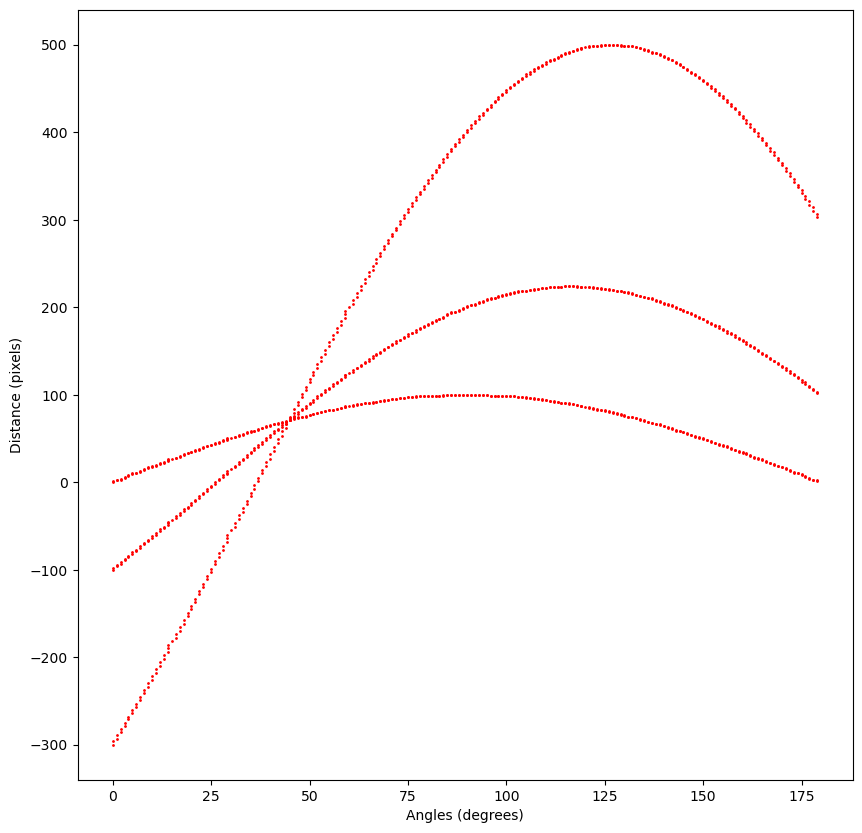

In [5]:
M = 500 # number of rows of the image
N = 500 # number of columns of the omage
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
ax.set_xlabel('Angles (degrees)')
ax.set_ylabel('Distance (pixels)')
x = [200, 400, 100]
y = [100, 300, 0] # y = x + 100 (theta = 45, rho = 71 pixels)
for i in range(0, len(x)):
    theta, r = hough_line(x[i], y[i], M, N, 360)
    ax.plot(theta, r, color='red', marker='o', linestyle='None', markersize=1)

plt.savefig('hough_lines.png')

We can see from the plot that the three sinusoidal curves that represent the three pixels in the parameter space cross each other at 45 degrees. It is less clear to discern the value of the distance, that should be 71 pixels, but we can say it's in the right section of the plot. We will see how to use the accumulator matrix to derive both values.  

### The accumulator matrix
Now we create the accumulator matrix to store the set of values of the Hough transform that we compute with the hough_line() function for each edge pixel. We can see that the value of the distance parameter $\rho$ can be negative for certain values of the pixel coordinates and of the angle $\theta$. We set the size of the accumulator for the distance to the maximum distance between two pixels in the image. Since NumPy cannot use negative values for indexes we get the absolute value of the distance. In this way we will be able to store the votes for any point in the parameters space.   

In [6]:
def accumulate(image, num_angles = 180):
    '''
    The function takes an input image and computes the Hughes trasform for
    all the (edge) pixels whose value is above a threshold (default is 0).
    M is the number of rows of the image, N is the number of columns.
    Theta and rho are arrays that contain the quantized values of the Hough 
    transform of a pixel in normal form. The function returns the accumulator matrix.
    The value of each accumulator's cell represents the number of votes reached by
    the line in the image that is represented by it.
    '''
    M = image.shape[0]
    N = image.shape[1]
    max_r = np.rint(np.sqrt(M * M + N * N)).astype(int)
    accumulator = np.zeros((max_r, num_angles), dtype=int)
    counter = 0
    for u in range(0, M):
        for v in range(0, N):
            if image[u, v] > 0:
                theta, rho = hough_line(u, v, M, N, num_angles)
                for t in range(0, theta.shape[0]):
                    i = np.absolute(rho[t])
                    j = theta[t]
                    accumulator[i, j] += 1
                    
    return accumulator

We create an image with a triangular shape and then we use the accumulate() function to record the Hough transform of each pixel that belongs to any of the three lines that form the triangle. We record in each accumulator's cell $A[i_{\rho}, j_{\theta}]$, the number of curves that pass through it. Since the edges are drawn lines, without noise or blurring, we can safely say that we would be able to distinguish two lines that are separated by e.g. 0.5 degrees, so that we can set the number of angles in which we split $\pi$ radians to 360.  

In [7]:
M = 400
N = 400

line11 = dip_line(100, 100, 100, 300, M, N) # horizontal 90 deg
line12 = dip_line(100, 100, 300, 100, M, N) # vertical 0 deg
line13 = dip_line(100, 300, 300, 100, M, N) # diagonal negative
lines_img = line11 + line12 + line13

acc1 = accumulate(lines_img, 360)
acc1.shape

(566, 360)

We can find the cell containing the maximum value in the accumulator matrix using a NumPy function. We can easily recognize the line as the one in the image that forms an angle of 135 degrees with the y axis, and whose distance from the origin is 200 * $\sqrt{2}$. We can expect two other most voted lines whose value is lower than this, but still higher than any other candidate line.

In [8]:
i, j = np.unravel_index(np.argmax(acc1, axis=None), acc1.shape) # search the cell indexes of the maximum value
print("Distance from origin (pixels): %.0d, Angle (deg): %.0d, Votes: %.0d"%(i, j, acc1[i,j]))

Distance from origin (pixels): 283, Angle (deg): 135, Votes: 284


Next, we plot the image and the corresponding accumulator matrix. We notice four points in the Hough transform diagram with the highest values: the point at 135 degrees, that has the highest number of votes, one at 90 degree, that represents the horizontal line in the image, and two other points at 0 and 180 degree that represent the same vertical line in the image.  

(350.0, 0.0)

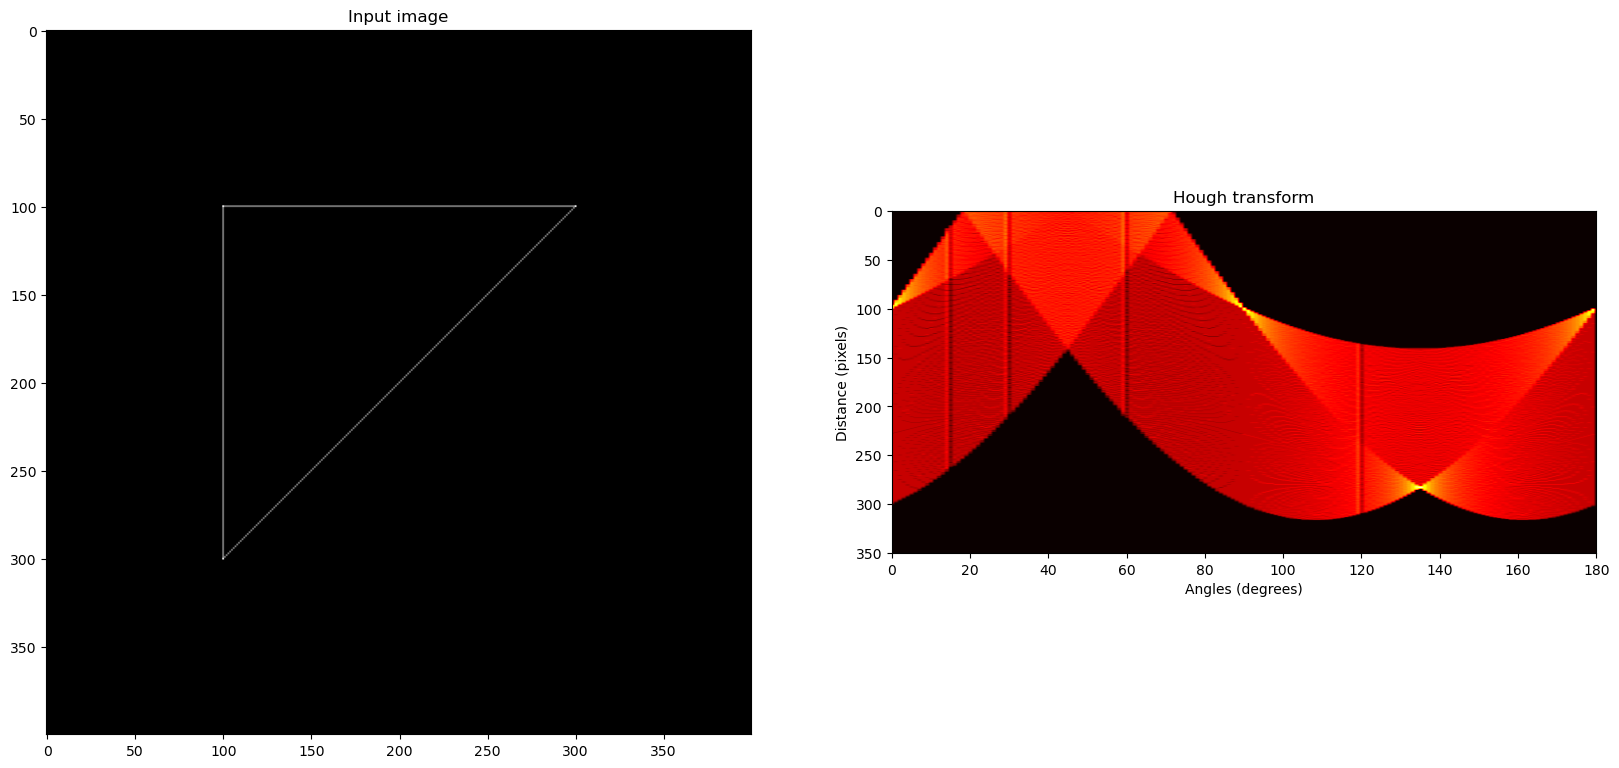

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(20, 20))
axes[0].imshow(lines_img, cmap=cm.gray)
axes[0].set_title('Input image')
axes[1].imshow(np.log(acc1 + 1), cmap=cm.hot, aspect=1/4)
axes[1].set_title('Hough transform')
axes[1].set_xlabel('Angles (degrees)')
axes[1].set_ylabel('Distance (pixels)')
axes[1].set_xlim(0, 180)
axes[1].set_ylim(350, 0)
#plt.savefig('hough_triangle.png')

We want to extract the cells $(\theta, \rho)$ in the accumulator matrix that have the highest number of votes, also called peaks, as they represent the lines in the image that pass through the highest number of edge pixels. There are more efficient ways to extract the highest values in a 2D array, but in this notebook we simply use a brute-force algorithm to extract the peaks from the accumulator matrix, namely the cells whose value, or number of votes, is above a threshold. We define the peaks() function to perform this task.  

In [10]:
def peaks(accumulator, threshold):
    '''
    The function takes as input an accumumulator map and a
    threshold that represent the minimum value of the accumulator's
    cell to be included in the list of candidate lines.
    '''
    M = accumulator.shape[0]
    N = accumulator.shape[1]
    #Yr = np.rint(0.5 * M).astype(int)
    theta = []
    rho = []
    value = []
    lines = [theta, rho, value]
    for r in range(0, M):
        for c in range(0, N):
            if accumulator[r, c] >= threshold:
                theta.append(c)
                rho.append(r)
                value.append(accumulator[r, c])
    return lines

We use the peaks() function to extract the points in the parameter space whose number of votes is above a threshold. In the case of the geometrical shape example, we set the threshold to 200, not too close and not too far from the maximum value. We can see that we get three points that represent the three lines in the image that form our triangle. 

In [11]:
lines = peaks(acc1, 200)
for i in range(0, len(lines[0])):
    print("Angle (deg): %.0d, Distance (pixels): %.0d,  Votes: %.0d"%(lines[0][i], lines[1][i], lines[2][i]))

Angle (deg): 0, Distance (pixels): 100,  Votes: 203
Angle (deg): 90, Distance (pixels): 100,  Votes: 201
Angle (deg): 135, Distance (pixels): 283,  Votes: 284


After we have got the angle $\theta$ and distance $\rho$ of the most voted lines in our image, we want to compute the respective slopes and intercepts. We define a function for doing just that.

In [12]:
def hough2image(theta, rho):
    intercept = rho
    slope = np.inf
    if theta > 0 and theta < 180:
        theta_rad = np.deg2rad(theta)
        slope = np.cos(theta_rad) / np.sin(theta_rad)
        intercept = rho / np.sin(theta_rad)
    return slope, intercept

Let's use the function just defined to get the slopes and intercepts of the three lines that form our triangle

In [13]:
for i in range(0, len(lines[0])):
    theta = lines[0][i]
    rho = lines[1][i]
    slope, intercept = hough2image(theta, rho)
    if slope != np.inf:
        print("Slope: %.0f, Intercept: %.0f"%(slope, intercept))
    else:
        print("Slope: Infinity, Intercept: %.0f"%(intercept))

Slope: Infinity, Intercept: 100
Slope: 0, Intercept: 100
Slope: -1, Intercept: 400


After we have tested the functions we needed to find lines in a picture using the Hough transform, and before using those functions on images with man-made objects, we perform another test with an image that contains a little more complex figure with two geometrical shapes, the triangle we have already used and a square box. We create the image and compute the accumulator matrix.

In [14]:
M = 500
N = 500
# triangle
line22 = dip_line(100, 100, 300, 100, M, N) # vertial
line23 = dip_line(100, 300, 300, 100, M, N) # diagonal
line21 = dip_line(100, 100, 100, 300, M, N) # horizontal

# square
line24 = dip_line(200, 200, 200, 400, M, N) # horizontal up
line25 = dip_line(400, 200, 400, 400, M, N) # horizontal down
line26 = dip_line(200, 200, 400, 200, M, N) # vertical left
line27 = dip_line(200, 400, 400, 400, M, N) # vertical right

lines_img1 = ((line21 + line22 + line23 + line24 + line25 + line26 + line27) >= 255) * 255  # input image
acc2 = accumulate(lines_img1, 360) # accumulator matrix of the input image

Then we plot the input image and the detected lines, setting the minimum threshold for the cells in the accumulator matrix to 50 votes first and then to 200.

Votes' threshold = 50. Number of detected lines: 139 
Votes' threshold = 200. Number of detected lines: 7 


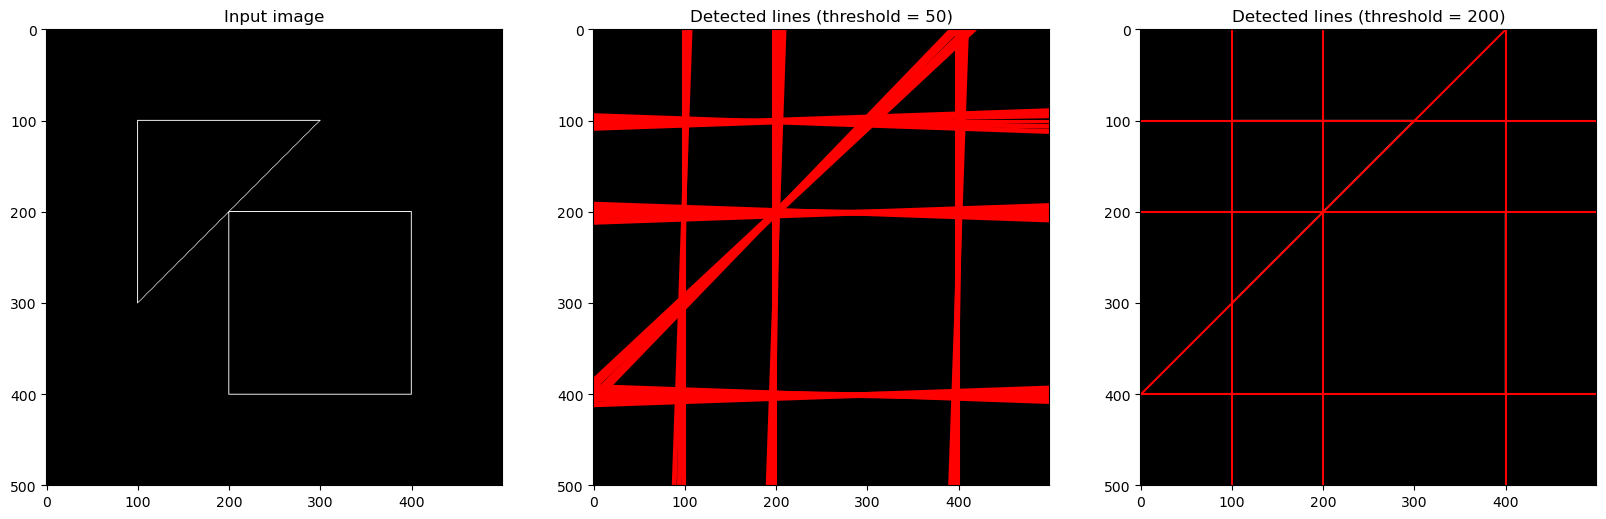

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 12))
# plot the input image
axes[0].imshow(lines_img1, cmap=cm.gray)
axes[0].set_title('Input image')
axes[0].set_ylim(M, 0)
    
# plot detected lines with threshold = 50 
axes[1].imshow(lines_img1, cmap=cm.gray)
x = np.linspace(0, lines_img1.shape[1] - 1, lines_img1.shape[1])
y = np.zeros(M, dtype=int)
threshold = 50
lines = peaks(acc2, threshold)
print("Votes' threshold = %.0d. Number of detected lines: %.0d "%(threshold, len(lines[0])))
for i in range(0, len(lines[0])):
    theta = lines[0][i]
    rho = lines[1][i]
    slope, intercept = hough2image(theta, rho)
    if slope != np.inf:
        y = slope * x + intercept
        axes[1].plot(x, y, color='red')
    elif intercept < M:
        axes[1].axvline(x=intercept, color='red')
    axes[1].set_ylim(M, 0)
    axes[1].set_title('Detected lines (threshold = 50)')
    
# plot detected lines with threshold = 200
axes[2].imshow(lines_img1, cmap=cm.gray)
x = np.linspace(0, lines_img1.shape[1] - 1, lines_img1.shape[1])
y = np.zeros(M, dtype=int)
threshold = 200
lines = peaks(acc2, threshold)
print("Votes' threshold = %.0d. Number of detected lines: %.0d "%(threshold, len(lines[0])))
for i in range(0, len(lines[0])):
    theta = lines[0][i]
    rho = lines[1][i]
    slope, intercept = hough2image(theta, rho)
    if slope != np.inf:
        y = slope * x + intercept
        axes[2].plot(x, y, color='red')
    elif intercept < M:
        axes[2].axvline(x=intercept, color='red')
    axes[2].set_ylim(M, 0)
    axes[2].set_title('Detected lines (threshold = 200)') 

#plt.savefig('shapes_transform.png')

## Images with man-made objects
Now that we have tested our implementation of the Hough transform with images containing geometrical shapes made up of dotted lines, we are ready to move on to the next step, namely, applying the algorithm to find lines in pictures containing man-made objects. When we use pictures of real objects, before looking for lines or other geometrical shapes, we have to detect the edges that reveal the border of objects or regions in the image. This step was not necessary in the previous examples because the edges of the geometrical shapes were drawn precisely using the equation of a line. Borders separating man-made or natural objects can be found using a thresholding function or an edge detector. Once edges have been detected, the next step is to link their pixels to find out lines for which we can determine the slope and the intercept. We perform the linking step using the Hough transform. We can build a pipeline of functions to find lines in pictures. We can add one more step to our pipeline to take into account the quantization error of the accumulator matrix for which the Hough lines may not intersect exactly in one single cell but more likely in a cluster of neighboring cells. We add a thresholding step after the edge detector to separate precisely the edges from the background. The complete steps that we will perform in the next example are the followings

1. Apply the gradient-based edge detector to an image to get its edge map.
2. Apply a threshold to the edge map to obtain a binary representation.
3. Apply the Hough transform to the foreground pixels of the binary edge map to build the accumulator matrix.
4. Suppress the nonmaximal cells from the accumulator matrix to reduce the quantization error
5. Set the minimum votes threshold to select the peaks in the accumulator matrix that correspond to straight lines in the image.
6. Compute the slopes and intercepts of the lines in the image corresponding to the peaks.
7. Plot the lines on the image.

We implement the function to take into account the quantization error by suppressing from the accumulator matrix the nonmaximal cells whose value is lower than any of its neighboring cells.

In [16]:
def dip_nonmaxFilter(accumulator, neighbor_dist = 1):
    '''
    Sets to zero the value of an accumulator cell if any of its neighbors 
    has an equal or higher value, that is, if the cell is nonmaximal.
    The filter looks at all the neighbors within a distance in pixels.
    The default neighbor distance is 1. The function returns the same 
    accumulator without the nonmaximal points.
    '''
    
    rows = accumulator.shape[0]
    cols = accumulator.shape[1]

    for col in range(0, cols - neighbor_dist):
        for row in range(0, rows - neighbor_dist):
            vote = accumulator[row, col]
            for i in range(-neighbor_dist, neighbor_dist + 1):
                for j in range(-neighbor_dist, neighbor_dist + 1):
                    v = accumulator[row + i, col + j]
                    is_center = (i == 0 and j == 0)
                    if v >= vote and not is_center:
                            accumulator[row, col] = 0    
    return accumulator

We find the edges on an image by applying a gradient filter, and then we build a binary image by applying a thresholding function that will enhance the separation between the edges and the background.

In [17]:
test_img = io.imread('images/airport.tif')
edge_map = dip_localGradient(test_img)
binary_img = dip_threshold(edge_map, 30, 255, 0)

We can now compute the accumulator matrix, suppress the nonmaximal cells in it within a certain distance from each cell, and select the candidate points in the parameter space with the highest votes.

In [ ]:
neighbor_dist = 5
accumulator = accumulate(binary_img)
acc_max = dip_nonmaxFilter(accumulator, neighbor_dist)

We set a threshold for the votes in the accumulator matrix to extract the peaks, i.e. the points in the parameter space with the highest votes, and the corresponding lines on the image. 

In [20]:
acc_threshold = 240
lines = lines = peaks(acc_max, acc_threshold)
print("Number of detected lines: %.0d"%(len(lines[0])))
for i in range(0, len(lines[0])):
    print("Line: %.0d, Angle (deg): %.0d, Distance (pixels): %.0d,  Votes: %.0d"%(i + 1, lines[0][i], lines[1][i], lines[2][i]))

Number of detected lines: 8
Line: 1, Angle (deg): 119, Distance (pixels): 248,  Votes: 326
Line: 2, Angle (deg): 119, Distance (pixels): 256,  Votes: 268
Line: 3, Angle (deg): 179, Distance (pixels): 259,  Votes: 272
Line: 4, Angle (deg): 179, Distance (pixels): 262,  Votes: 285
Line: 5, Angle (deg): 179, Distance (pixels): 291,  Votes: 353
Line: 6, Angle (deg): 179, Distance (pixels): 292,  Votes: 302
Line: 7, Angle (deg): 179, Distance (pixels): 299,  Votes: 242
Line: 8, Angle (deg): 179, Distance (pixels): 300,  Votes: 407


Finally, we plot the original image, the edge map, and again the original image with the lines that have been found superimposed on it.

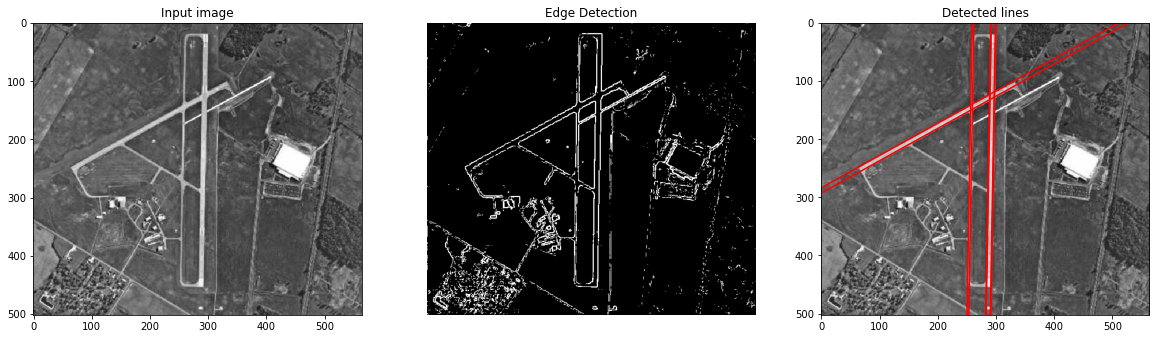

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
M = binary_img.shape[0]
N = binary_img.shape[1]
axes[0].imshow(test_img, cmap='gray')
axes[0].set_title('Input image')
#axes[0].set_ylim(M, 0)

axes[1].set_title('Edge Detection')
axes[1].set_axis_off()
axes[1].imshow(binary_img, cmap='gray')

axes[2].imshow(test_img, cmap=cm.gray)
x = np.linspace(0, binary_img.shape[1] - 1, binary_img.shape[1])
y = np.zeros(M, dtype=int)
for i in range(0, len(lines[0])):
    theta = lines[0][i]
    rho = lines[1][i]
    votes = lines[2][i]
    slope, intercept = hough2image(theta, rho)
    if slope != np.inf:
        y = slope * x + intercept
        axes[2].plot(x, y, color='red')
    else:
        axes[2].axvline(x=intercept, color='red')
    axes[2].set_ylim(M, 0)
    axes[2].set_title('Detected lines') 
plt.savefig('runway_detection_hough_transform.png')

We can see from the last picture that the Hough transform is able to determine the main lines, with their slopes and intercepts, that correspond to the borders of the runways of the airport. We can also notice that other lines, visible in the binary image, have not been included in the set that resulted from our settings of the parameters. This is mainly due to the fact that those lines are shorter or contain less edge pixels than the two runways. This bias towards longer lines can be addressed, for example by dividing the image in smaller boxes and then applying the Hough transform to each of them, or by finding the pixels that delimit the lines in the binary image and then looking for the corresponding lines in the accumulator matrix.     

## Conclusion
The Hough transform can be used to extract lines from images with a complexity cost that is linear with respect to the number of edge pixels. We have shown the basic functions that are required to implement the Hough transform for which some manual settings are required, such as the quantization of the parameter space, the votes threshold and the neighboring distance for the accumulator matrix.   